# Parametric Blocks and sweeps
In this example, the parametric building blocks, and their usage, is illustrated. 

## Parameters handling
Sometimes, it would be nicer to change some parameter of the simulation without redefine the entire cell. This is achieved by using parametric models. One great example of that is a model for the Phase Shifter. It is a simple 2 ports components which can apply variable phase shift (measured in pi units).

We will employ this phase shifter inside a MZM:

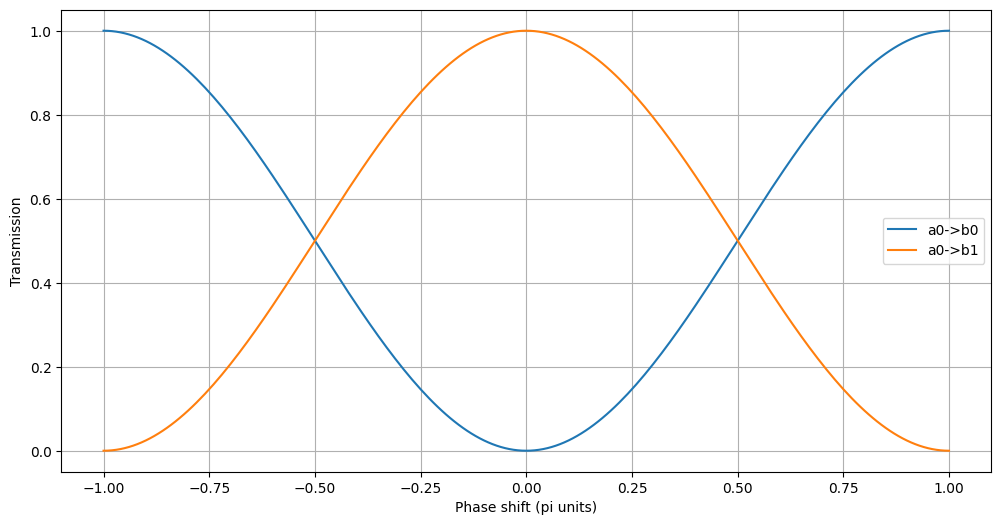

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import lekkersim as lk

with lk.Solver() as MZM:
    WG=lk.Waveguide(L=10.0, n=2.5)
    BM=lk.BeamSplitter(ratio=0.5)
    PS=lk.PhaseShifter(param_name='PS')
    
    bm1=BM.put()
    wg1=WG.put('a0',bm1.pin['b0'])
    wg2=WG.put('a0',bm1.pin['b1'])
    ps =PS.put('a0',wg1.pin['b0'])
    bm2=BM.put('a0',ps.pin['b0'])

    lk.connect(wg2.pin['b0'],bm2.pin['a1'])
    
    lk.Pin('a0').put(bm1.pin['a0'])
    lk.Pin('a1').put(bm1.pin['a1'])
    lk.Pin('b0').put(bm2.pin['b0'])
    lk.Pin('b1').put(bm2.pin['b1'])
    
b0l,b1l = [], []
psl=np.linspace(-1.0,1.0,201)  
for ps in psl:
    MOD=MZM.solve(wl=1.55,PS=ps)
    b0l.append(MOD.get_T('a0','b0'))
    b1l.append(MOD.get_T('a0','b1'))
    
plt.figure(figsize=[12.0, 6.0])    
plt.plot(psl, b0l, label='a0->b0')
plt.plot(psl, b1l, label='a0->b1')
plt.xlabel('Phase shift (pi units)')
plt.ylabel('Transmission')
plt.grid()
plt.legend() 

Each parametric building block has his own name for the parameter.The same name (in the case of the Phase Shifter is 'PS' has to be passed to solve in order to be set). This creates a conflict when multiple parametric models are added with the same parameter name. In order to solve the problem, an option to map the parameters name to a new name is provided by the put statement. To rename the parameters of the model, a dictionary containing the name mapping (`{ oldname : newname}`) has to be provided in the put. This allows the independent control of each instance of a parametric model. 

A small note one the use of parameters in hierarchical simulation. It is better to think as the parameter name to be global variables. This because the same BB could be placed at different levels, and the mapping between parameter and component has to be unique. 

To illustrate this, here is an example of the same MZM, but with a phase shifter in each arm. In order the see the different effect due to the phase shifters in each arm, 

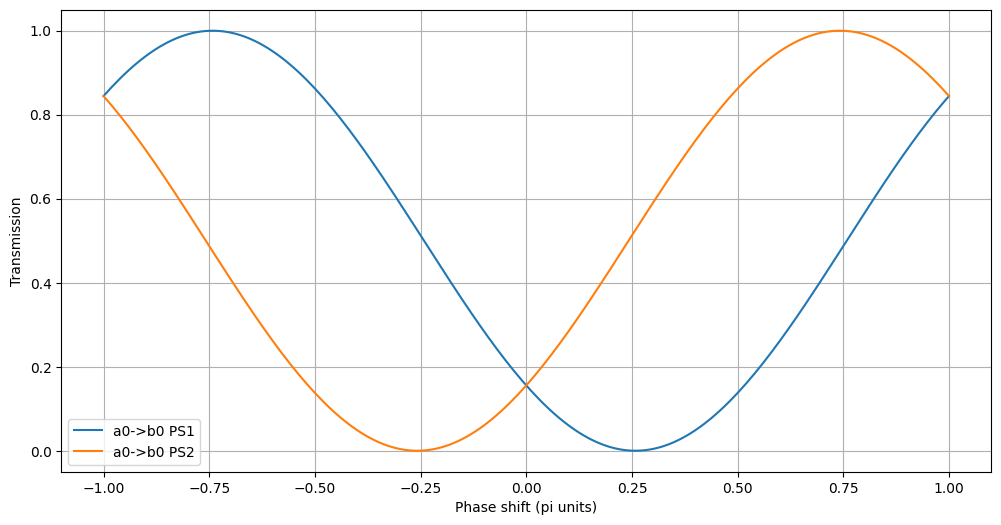

In [13]:
with lk.Solver() as MZM:
    WG=lk.Waveguide(L=10.0, n=2.5)
    BM=lk.BeamSplitter(ratio=0.5)
    PS=lk.PhaseShifter(param_name='PS')
    
    bm1=BM.put()
    wg1=WG.put('a0',bm1.pin['b0'])
    wg2=WG.put('a0',bm1.pin['b1'])
    wg2=WG.put('a0',wg2.pin['b0'])
    ps1 =PS.put('a0',wg1.pin['b0'],param_mapping={'PS': 'PS1'})
    ps2 =PS.put('a0',wg2.pin['b0'],param_mapping={'PS': 'PS2'})

    bm2=BM.put('a0',ps1.pin['b0'])
    lk.connect(ps2.pin['b0'],bm2.pin['a1'])
    
    lk.Pin('a0').put(bm1.pin['a0'])
    lk.Pin('a1').put(bm1.pin['a1'])
    lk.Pin('b0').put(bm2.pin['b0'])
    lk.Pin('b1').put(bm2.pin['b1'])
   
psl=np.linspace(-1.0,1.0,201)  
Tl1,Tl2 = [], []
for ps in psl:
    MOD=MZM.solve(wl=1.55, PS1=ps, PS2=0.0)
    Tl1.append(MOD.get_T('a0','b0'))
    MOD=MZM.solve(wl=1.55, PS1=0.0, PS2=ps)
    Tl2.append(MOD.get_T('a0','b0'))
    
plt.figure(figsize=[12.0, 6.0])
plt.plot(psl, Tl1, label='a0->b0 PS1')
plt.plot(psl, Tl2, label='a0->b0 PS2')
plt.xlabel('Phase shift (pi units)')
plt.ylabel('Transmission')
plt.grid()
plt.legend()

In the hierarchical simulation, the renaming of the parameters could be used at multiple levels, even on already mapped names. For example, we could reuse the model for the balanced modulator in order to simulate a more complex I/Q modulator. Note that in the following script the function `get_A` is used to get directly the complex amplitude of the transmission, since in a IQ modulator the phase of the output signal is as important as the amplitude. 

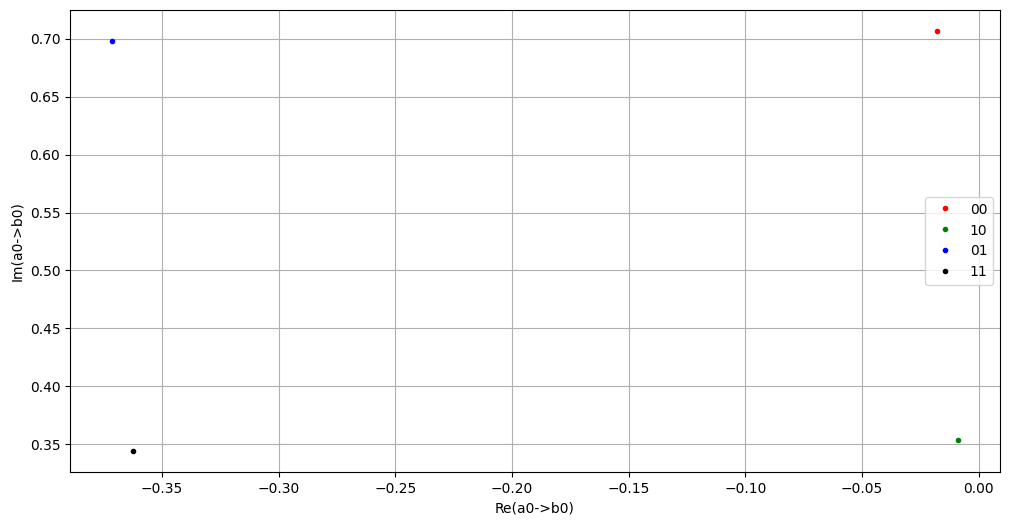

In [14]:
with lk.Solver(name='MZM') as MZM_bal:
    WG=lk.Waveguide(L=10.0, n=2.5)
    BM=lk.BeamSplitter(ratio=0.5)
    PS=lk.PhaseShifter(param_name='PS')
    
    bm1=BM.put()
    wg1=WG.put('a0',bm1.pin['b0'])
    wg2=WG.put('a0',bm1.pin['b1'])
    ps1 =PS.put('a0',wg1.pin['b0'],param_mapping={'PS': 'PS1'})
    ps2 =PS.put('a0',wg2.pin['b0'],param_mapping={'PS': 'PS2'})

    bm2=BM.put('a0',ps1.pin['b0'])
    lk.connect(ps2.pin['b0'],bm2.pin['a1'])
    
    lk.Pin('a0').put(bm1.pin['a0'])
    lk.Pin('a1').put(bm1.pin['a1'])
    lk.Pin('b0').put(bm2.pin['b0'])
    lk.Pin('b1').put(bm2.pin['b1'])
    
with lk.Solver(name='IQ_mod') as IQ_mod:
    BM=lk.BeamSplitter(ratio=0.5)
    PS=lk.PhaseShifter(param_name='PS')
    
    bm1=BM.put()
    mz1=MZM_bal.put('a0',bm1.pin['b0'],param_mapping={'PS1' : 'I1', 'PS2' : 'I2'})
    mz2=MZM_bal.put('a0',bm1.pin['b1'],param_mapping={'PS1' : 'Q1', 'PS2' : 'Q2'})
    ps1=PS.put('a0',mz1.pin['b1'], param_mapping={'PS' : 'I'})
    ps2=PS.put('a0',mz2.pin['b1'], param_mapping={'PS' : 'Q'})
    bm2=BM.put('a0',ps1.pin['b0'])
    lk.connect(ps2.pin['b0'],bm2.pin['a1'])
    
    lk.Pin('a0').put(bm1.pin['a0'])
    lk.Pin('a1').put(bm1.pin['a1'])
    lk.Pin('b0').put(bm2.pin['b0'])
    lk.Pin('b1').put(bm2.pin['b1'])
    
    lk.Pin('DumIn0').put(mz1.pin['a1'])
    lk.Pin('DumIn1').put(mz2.pin['a1'])
    lk.Pin('DumOut0').put(mz1.pin['b0'])
    lk.Pin('DumOut1').put(mz2.pin['b0'])
    
#IQ_mod.show_connections()
#IQ_mod.show_free_pins()

plt.figure(figsize=[12.0, 6.0])

MOD=IQ_mod.solve(wl=1.55, I1=0.0, I2=0.0, Q1=0.0, Q2=0.0, I=0.0, Q=0.5)
T=MOD.get_A('a0','b0')
plt.plot(T.real,T.imag,'r.',label='00')

MOD=IQ_mod.solve(wl=1.55, I1=0.5, I2=0.0, Q1=0.0, Q2=0.0, I=0.0, Q=0.5)
T=MOD.get_A('a0','b0')
plt.plot(T.real,T.imag,'g.',label='10')

MOD=IQ_mod.solve(wl=1.55, I1=0.0, I2=0.0, Q1=0.5, Q2=0.0, I=0.0, Q=0.5)
T=MOD.get_A('a0','b0')
plt.plot(T.real,T.imag,'b.',label='01')

MOD=IQ_mod.solve(wl=1.55, I1=0.5, I2=0.0, Q1=0.5, Q2=0.0, I=0.0, Q=0.5)
T=MOD.get_A('a0','b0')
plt.plot(T.real,T.imag,'k.',label='11')

plt.xlabel('Re(a0->b0)')
plt.ylabel('Im(a0->b0)')
plt.legend()
plt.grid()

As can be seen, this renaming of parameters offers a pretty flexible and intuitive way of building up and controlling circuits with many parametric building blocks. 

## Keeping track of the parameters
Given the possibility of renaming the parameters at every step, keeping track can bee a challenge. For this reason, each model comes with its own dictionary of default parameters (in some case the default is None, so the simulation will fail unless a valid value is provided to solve). Every something is placed, the default value of the parameters will be passed up using the re-mapped name. A few functions are then provided in order to check the available parameters:

- `show_default_params`: Print all the top level parameters and the respective default values. Useful to see if the mapping is correct and which parameter are available for setting. 
Here is the output on `MZM_bal`: 

In [15]:
MZM_bal.show_default_params()

Default params of Solver of MZM (id=140070472883984):
  wl        : 1.0
  PS1       : 0.0
  PS2       : 0.0


And on `IQ_mod`:

In [16]:
IQ_mod.show_default_params()

Default params of Solver of IQ_mod (id=140070471827344):
  wl        : 1.0
  I1        : 0.0
  I2        : 0.0
  Q1        : 0.0
  Q2        : 0.0
  I         : 0.0
  Q         : 0.0


## Definition of new parameters
When building a solver, it is also possible to include some knowledge about the the components to be modeled. This can be done my defining some new parameter, and linking the value of some older parameters to the new one. This can be done with the function `add_param`.

In the following example, a thermal phase shifter is created, and the phase shift is related to the voltage applied in the component by setting the Phase Shift provided by the template model using an user defined function and parameters. 

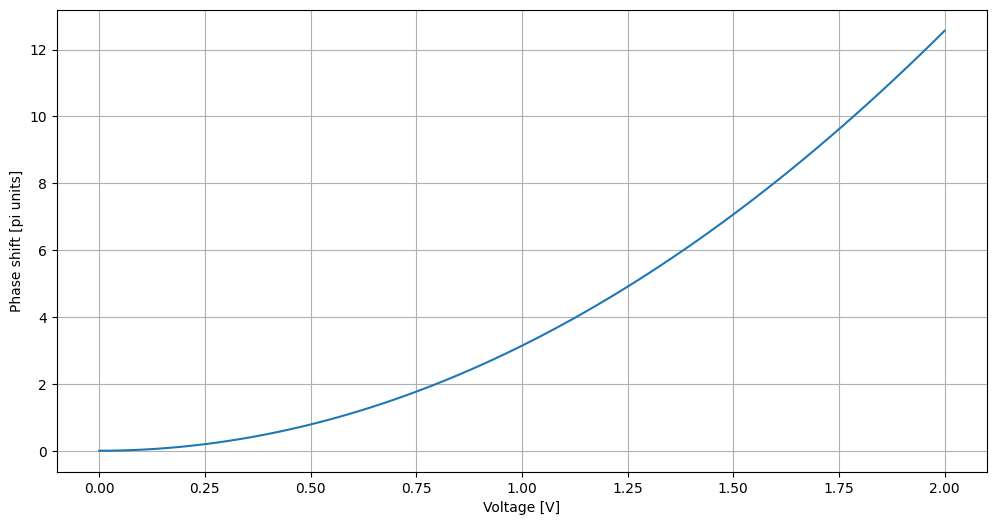

In [17]:
def V2PS(V=0.0):
    return V**2.0

with lk.Solver() as TH_PS:
    ps = lk.PhaseShifter().put()
    lk.add_param('PS', V2PS, {'V' : 0.0})
    lk.raise_pins()
    
fig = plt.figure(figsize=(12,6))
data = TH_PS.solve(V = np.linspace(0.0,2.0,101)).get_data('a0', 'b0')
plt.plot(data['V'], np.unwrap(data['Phase']))
plt.xlabel('Voltage [V]')
plt.ylabel('Phase shift [pi units]')
plt.grid()

As can be see, `add_params` takes 3 arguments, namely:
 - a string, containing the name of the old parameter to be set
 - a function, relating the old parameter to the new one(s)
 - a dictionary, containing the default value of the parameters for the function.
 
It is worth noting that the default parameter can be omitted, and, if possible, will be extracted using introspection on the function:

## Usage of arrays in solve for fastest sweeps

Until now, every time a parametric sweep was needed, the loop and the plotting was performed manually. A much quicker way is provided by feeding into the `solve` method some array-like object (list or numpy array). The data can then be extracted with the method `get_data`, which, given two ports, returns a pandas DataFrame containing the values of all the parameters together with the transmission, phase and amplitude between the selected ports. Here is an example on the 'MZM' object:

,wl,PS1,PS2,T,dB,Phase,Amplitude
0,1.55,-1.00,0.5,0.137604,-8.613702,-1.140094,0.154875-0.337072j
1,1.55,-0.99,0.5,0.148603,-8.279727,-1.124386,0.166428-0.347713j
2,1.55,-0.98,0.5,0.159949,-7.960184,-1.108678,0.178310-0.357987j
3,1.55,-0.97,0.5,0.171631,-7.654050,-1.092970,0.190508-0.367882j
4,1.55,-0.96,0.5,0.183636,-7.360411,-1.077262,0.203011-0.377389j
...,...,...,...,...,...,...,...
196,1.55,0.96,0.5,0.097286,-10.119497,-1.202926,0.112171-0.291039j
197,1.55,0.97,0.5,0.106793,-9.714565,-1.187218,0.122299-0.303045j
198,1.55,0.98,0.5,0.116688,-9.329722,-1.171510,0.132799-0.314726j
199,1.55,0.99,0.5,0.126962,-8.963264,-1.155802,0.143662-0.326073j


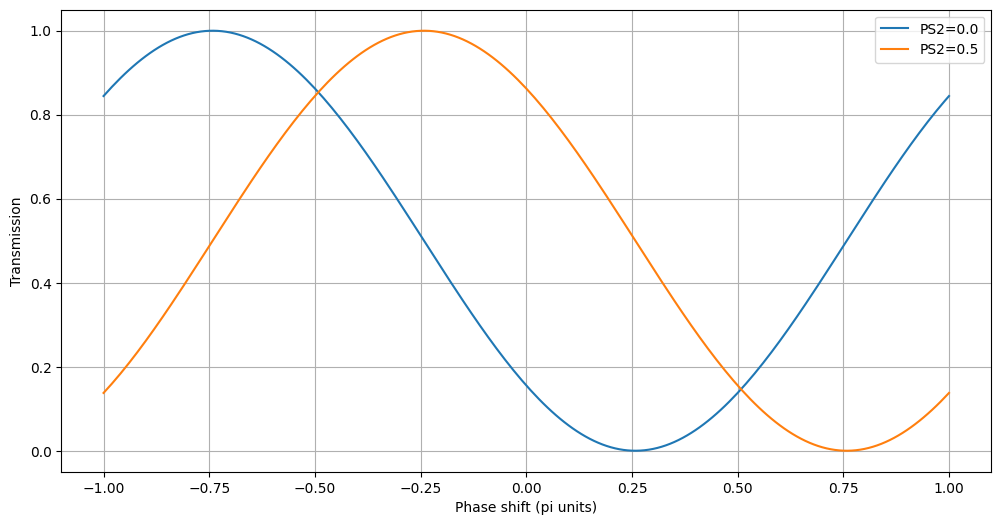

In [18]:
plt.figure(figsize=[12.0, 6.0])

T=MZM.solve(wl=1.55, PS1=np.linspace(-1.0,1.0,201), PS2=0.0).get_data('a0','b0')
plt.plot(T['PS1'],T['T'],label='PS2=0.0')

T=MZM.solve(wl=1.55, PS1=np.linspace(-1.0,1.0,201), PS2=0.5).get_data('a0','b0')
plt.plot(T['PS1'],T['T'],label='PS2=0.5')

plt.xlabel('PS1')
plt.ylabel('T a0->b0')
plt.legend()
plt.xlabel('Phase shift (pi units)')
plt.ylabel('Transmission')
plt.grid()
T

More than a parameter can be an array in one single solve call. Since all array parameters are looped together, every array-like parameter needs to have the same shape. Here is an example:

,wl,PS1,PS2,T,dB,Phase,Amplitude
0,1.55,-1.00,1.00,0.155517,-8.082234,2.786897,-0.369808+0.136962j
1,1.55,-0.99,0.99,0.133441,-8.747099,2.786897,-0.342557+0.126869j
2,1.55,-0.98,0.98,0.112813,-9.476425,2.786897,-0.314968+0.116651j
3,1.55,-0.97,0.97,0.093712,-10.282049,2.786897,-0.287069+0.106319j
4,1.55,-0.96,0.96,0.076215,-11.179607,2.786897,-0.258886+0.095881j
...,...,...,...,...,...,...,...
196,1.55,0.96,-0.96,0.256463,-5.909745,2.786897,-0.474898+0.175883j
197,1.55,0.97,-0.97,0.229525,-6.391708,2.786897,-0.449265+0.166390j
198,1.55,0.98,-0.98,0.203653,-6.911087,2.786897,-0.423188+0.156732j
199,1.55,0.99,-0.99,0.178951,-7.472650,2.786897,-0.396694+0.146919j


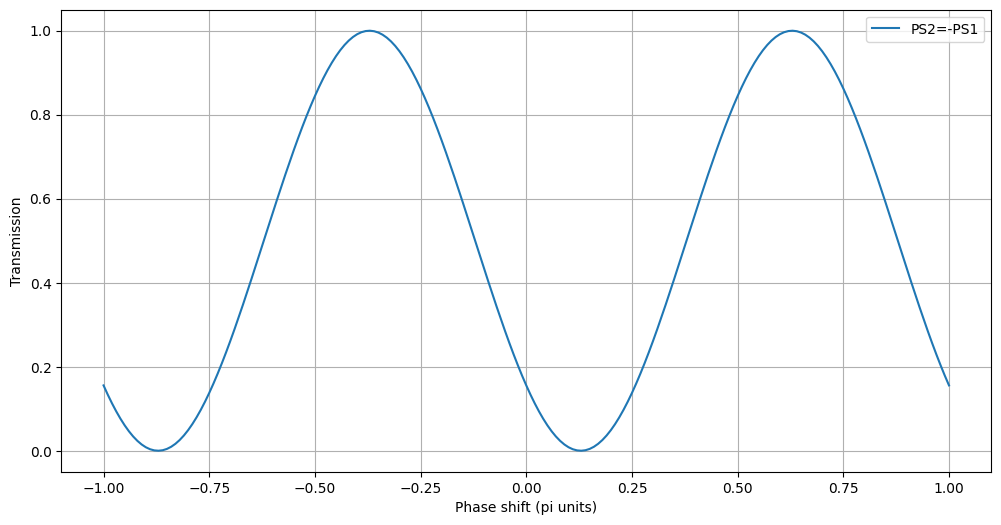

In [19]:
plt.figure(figsize=[12.0, 6.0])

T=MZM.solve(wl=1.55, PS1=np.linspace(-1.0,1.0,201), PS2=np.linspace(1.0,-1.0,201)).get_data('a0','b0')
plt.plot(T['PS1'],T['T'],label='PS2=-PS1')

plt.xlabel('PS1')
plt.ylabel('T a0->b0')
plt.legend()
plt.xlabel('Phase shift (pi units)')
plt.ylabel('Transmission')
plt.grid()
T

It is also possible to loop two parameters independently, by using the `np.meshgrid` command:

/tmp/ipykernel_56905/2656603742.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  Z=T.pivot('PS1','PS2', 'T').values


,wl,PS1,PS2,T,dB,Phase,Amplitude
0,1.55,-1.0,-1.00,0.155517,-8.082234,2.786897,-0.369808+0.136962j
1,1.55,-1.0,-0.98,0.178951,-7.472650,2.818313,-0.401113+0.134386j
2,1.55,-1.0,-0.96,0.203653,-6.911087,2.849729,-0.432195+0.129850j
3,1.55,-1.0,-0.94,0.229525,-6.391708,2.881144,-0.462930+0.123371j
4,1.55,-1.0,-0.92,0.256463,-5.909745,2.912560,-0.493198+0.114976j
...,...,...,...,...,...,...,...
10196,1.55,1.0,0.92,0.076215,-11.179607,2.661233,-0.244827+0.127572j
10197,1.55,1.0,0.94,0.093712,-10.282049,2.692649,-0.275789+0.132862j
10198,1.55,1.0,0.96,0.112813,-9.476425,2.724065,-0.307022+0.136198j
10199,1.55,1.0,0.98,0.133441,-8.747099,2.755481,-0.338403+0.137567j


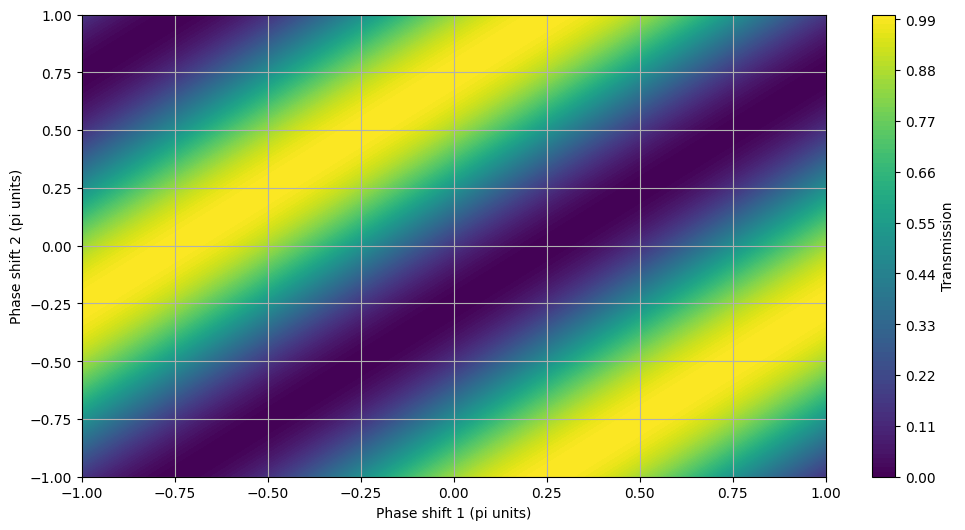

In [20]:
ps=np.linspace(-1.0,1.0,101)
P1,P2=np.meshgrid(ps,ps,indexing='ij')
T=MZM.solve(wl=1.55, PS1=P1, PS2=P2).get_data('a0','b0')
fig = plt.figure(figsize=[12.0, 6.0])
Z=T.pivot('PS1','PS2', 'T').values
plt.contourf(P1,P2,Z, levels=101)
plt.xlabel('Phase shift 1 (pi units)')
plt.ylabel('Phase shift 2 (pi units)')
plt.grid()
plt.colorbar(label = 'Transmission')
T